#Download Fashion MNIST dataset

##Import necessary modules

In [0]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

26427392it [00:02, 9427568.66it/s]                              


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 71749.87it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 2956914.77it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 25720.16it/s]            


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## Define the network

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [0]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [0]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [0]:
equals = top_class == labels.view(*top_class.shape)

In [0]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 14.0625%


##Loss Function and optimizer

In [0]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.515..  Test Loss: 0.473..  Test Accuracy: 0.829
Epoch: 2/10..  Training Loss: 0.394..  Test Loss: 0.393..  Test Accuracy: 0.861
Epoch: 3/10..  Training Loss: 0.360..  Test Loss: 0.409..  Test Accuracy: 0.852
Epoch: 4/10..  Training Loss: 0.338..  Test Loss: 0.373..  Test Accuracy: 0.867
Epoch: 5/10..  Training Loss: 0.318..  Test Loss: 0.366..  Test Accuracy: 0.869
Epoch: 6/10..  Training Loss: 0.307..  Test Loss: 0.350..  Test Accuracy: 0.878
Epoch: 7/10..  Training Loss: 0.295..  Test Loss: 0.360..  Test Accuracy: 0.871
Epoch: 8/10..  Training Loss: 0.286..  Test Loss: 0.356..  Test Accuracy: 0.879
Epoch: 9/10..  Training Loss: 0.277..  Test Loss: 0.369..  Test Accuracy: 0.875
Epoch: 10/10..  Training Loss: 0.267..  Test Loss: 0.368..  Test Accuracy: 0.870


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

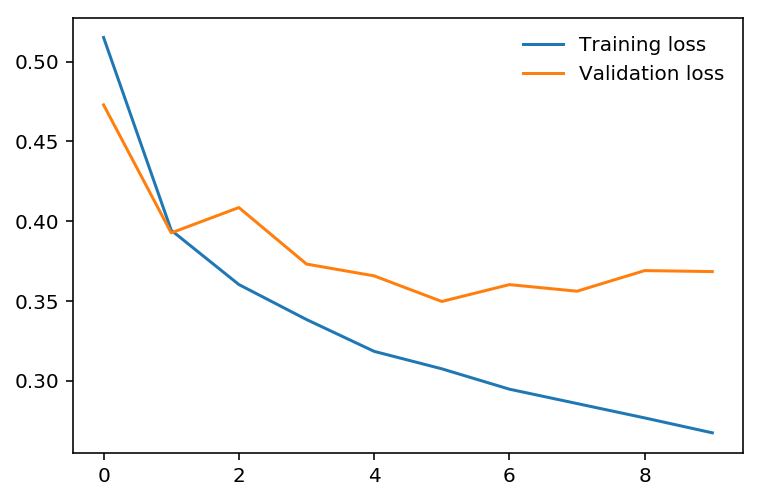

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Dropout to avoid Overfitting

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [0]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.605..  Test Loss: 0.491..  Test Accuracy: 0.823
Epoch: 2/10..  Training Loss: 0.487..  Test Loss: 0.446..  Test Accuracy: 0.843
Epoch: 3/10..  Training Loss: 0.451..  Test Loss: 0.455..  Test Accuracy: 0.835
Epoch: 4/10..  Training Loss: 0.435..  Test Loss: 0.412..  Test Accuracy: 0.854
Epoch: 5/10..  Training Loss: 0.416..  Test Loss: 0.401..  Test Accuracy: 0.860
Epoch: 6/10..  Training Loss: 0.413..  Test Loss: 0.416..  Test Accuracy: 0.856
Epoch: 7/10..  Training Loss: 0.401..  Test Loss: 0.382..  Test Accuracy: 0.864
Epoch: 8/10..  Training Loss: 0.393..  Test Loss: 0.390..  Test Accuracy: 0.860
Epoch: 9/10..  Training Loss: 0.392..  Test Loss: 0.403..  Test Accuracy: 0.862
Epoch: 10/10..  Training Loss: 0.398..  Test Loss: 0.388..  Test Accuracy: 0.866


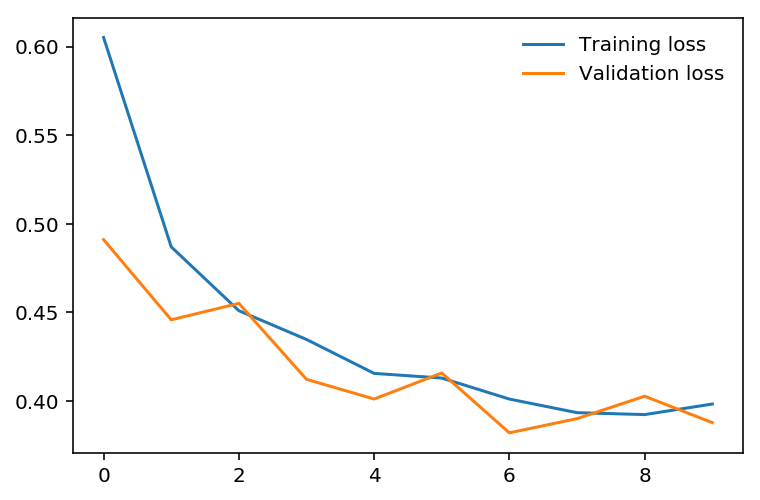

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

##Test

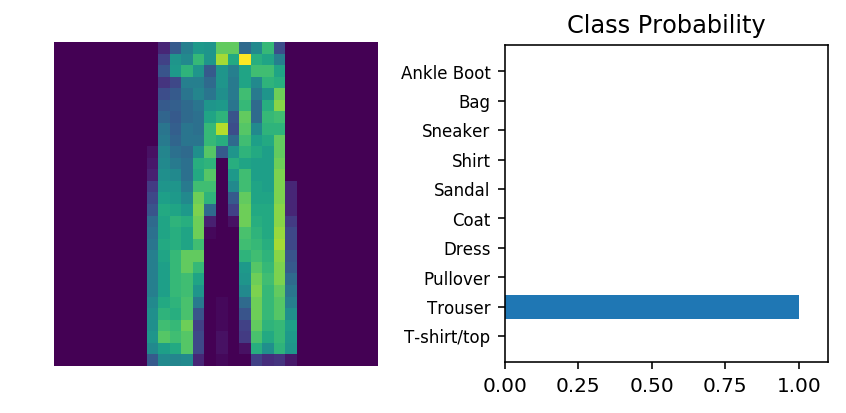

In [0]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')